# Solving a 1st-order ODE IVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to solve a 1st-order ordinary differential equation (ODE) initial value problem (IVP), using the `NNODE1IVP` class. The module allows the user to solve these equations using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Any 1st-order ODE can be written in the form:

\begin{equation}
G\left(x,y,\frac {dy}{dx}\right) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the initial condition:

\begin{equation}
y(0) = A
\end{equation}

where $A$ is a constant. The network is trained using a set of *training points* $x_i$ ($1 \le i \le n$), defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution, i.e. the neural network training is *unsupervised*. Such an ODE can always be mapped onto the domain $[0,1]$, and this code assumes such mapping has already been performed. For 1st-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A + P(x_i)N(x_i)
\end{equation}

The constant $A$ represents the initial condition, and the coefficient function $P(x)$ is defined to vanish at $x=0$. For 1st-order ODE IVP, the form of $P(x_i)$ is particularly simple:

\begin{equation}
P(x_i)=x_i
\end{equation}

Note that $P$ is a function only of $x$, while $N$ is a function of both $x$ and the neural network parameters $\vec p$. The trial solution can be written more compactly as:

\begin{equation}
y_{ti} = A + x_i N_i
\end{equation}

where $y_{ti}=y_t(x_i)$ is the value of the trial solution at the current training point $x_i$, and $N_i=N(x_i)$ is the single-valued floating-point output from a neural network with parameters $\vec p$ and input $x_i$. Note that this trial solution satisfies the initial condition by construction - at $x=0$, the second term vanishes, leaving $y_t(0)=A$.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{i=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G\left(x_i,y_{ti},\frac {dy_{ti}}{dx_i}\right)
\end{equation}

and $\frac {dy_{ti}}{dx_i}$ is the derivative of the trial function with respect to $x$, evaluated at $x_i$. This derivative is the current approximation of the solution derivative $\frac {dy}{dx}$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to the single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is transformed into the *activation* $z_{ik}$ by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ik}$ is the activation at hidden node $k$ using input $x_i$, $w_k$ is the weight at node $k$, and $u_k$ is the bias at node $k$. The weights and biases are initialized to random values in a user-specified range, typically $[-1,1]$. The activation is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

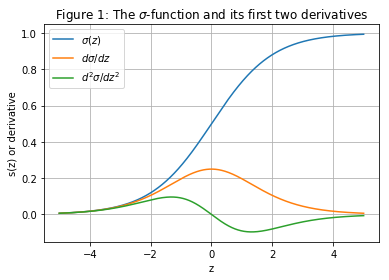

In [3]:
def sigma(z):
    return 1/(1 + exp(-z))

def dsigma_dz(z):
    return exp(-z)/(1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2*exp(-2*z)/(1 + exp(-z))**3 - exp(-z)/(1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
s = np.vectorize(sigma)(z)
s1 = np.vectorize(dsigma_dz)(z)
s2 = np.vectorize(d2sigma_dz2)(z)
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,s1,label = "$d\sigma/dz$")
plt.plot(z,s2, label = "$d^2\sigma/dz^2$")
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.grid()
plt.title("Figure 1: The $\sigma$-function and its first two derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed to create a new activation, which is used as the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivative $\frac {dy_{ti}}{dx_i}$ are computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights ($w_k$, $v_k$) and biases ($u_k$) of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: an input weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simplified Newton's method, commonly referred to as the "delta rule":

\begin{equation}
p_{new} = p - \eta \frac {\partial E}{\partial p}
\end{equation}

where $\eta$ is the *learning rate* ($\eta < 1$ by definition, for stability). The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until the specified maximum number of training epochs has been applied (convergence checks will be added later). Note that the same set of training points is presented during each epoch. Note also that since the error function for an epoch is only computed after all of the training points have been presented, the *order* of the training points is irrelevant.

## A note about derivatives

Since we are dealing with an ODE, all derivatives so far have been total derivatives with respect to $x$. The neural network output $N_i$ is also a function of the network parameters $\vec p$, so the notation will henceforth use partial derivatives to reflect this dependency when needed.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$, for a given $\vec p$, is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G\left(x_i,y_{ti},\frac {dy_{ti}}{dx_i}\right) =
\frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \left( \frac {dy_{ti}}{dx_i} \right)} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \left( \frac {dy_{ti}}{dx_i} \right)} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$ and $\frac {\partial G_i}{\partial \left( \frac {dy_{ti}}{dx_i} \right)}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the derivatives of $y_{ti}$ is (recall that $A$ is constant):

\begin{equation}
\frac {dy_{ti}}{dx_i} = P_i \frac {\partial N_i}{\partial x_i} + \frac {\partial P_i}{\partial x_i} N_i
\end{equation}

In the current case, $P_i=x_i$, so we are left with:

\begin{equation}
\frac {dy_{ti}}{dx_i} = x_i \frac {\partial N_i}{\partial x_i} + N_i
\end{equation}

Since $N_i$ is also a function of $\vec p$, the cross partial of $y_{ti}$ is:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i \frac {\partial^2 N_i}{\partial p \partial x_i} + \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {d\sigma_{ik}}{dz_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {d^n \sigma}{dz^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_{ik}$ with respect to the network parameters $\vec p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a trivial (but complete) problem which will illustrate how to use the `NNODE1IVP` class to solve a 1st-order ODE IVP.

## Define the ODE to solve, and the initial condition

Consider the simple 1st-order ODE IVP, defined on the domain $[0,1]$:

\begin{equation}
G\left(x,y,\frac {dy}{dx}\right) = x-y = 0
\end{equation}

The analytical solution to this equation is simply:

\begin{equation}
y(x) = x
\end{equation}

and the analytical derivative is:

\begin{equation}
\frac {dy}{dx}=1
\end{equation}

This analytical solution and its derivative are shown in the figure below.

In [4]:
def ya(x):
    return x

def dya_dx(x):
    return 1

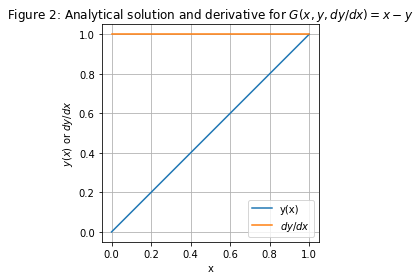

In [5]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.vectorize(ya)(x)
dy_dx = np.vectorize(dya_dx)(x)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('x')
plt.ylabel('$y(x)$ or $dy/dx$')
plt.grid()
ax.plot(x, y, label = 'y(x)'),
ax.plot(x, dy_dx, label = "$dy/dx$")
ax.set_aspect(1)
plt.legend()
plt.title("Figure 2: Analytical solution and derivative for $G(x,y,dy/dx)=x-y$");

Define the differential equation itself, and its derivatives.

In [6]:
# Define the original differential equation:
def G(x, y, dy_dx):
    return x - y

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx):
    return -1

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx):
    return 0

The initial condition is:

In [7]:
A = 0

For use in this code, the description of the differential equation must be encapsulated in an object. For 1st-order ODE IVPs, the relevant class is `ODE1IVP`:

In [8]:
from ode1ivp import ODE1IVP
ode = ODE1IVP()
ode.Gf = G
ode.dG_dyf = dG_dy
ode.dG_dydxf = dG_dydx
ode.ic = A
ode.yaf = ya
ode.dya_dxf = dya_dx

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [9]:
xmin = 0
xmax = 1
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator used when initializing the network parameters. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

The code below first creates the neural network object, then trains it. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `maxepochs`) are given default values (`0.01`, `10`, `1000`, respectively). The training method applies the training points to the network for the specified number of epochs. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the RMS error of $G_i$.

In [10]:
from nnode1ivp import NNODE1IVP
np.random.seed(0)
net = NNODE1IVP(ode)
net.train(xt, verbose = True)

0 0.40145299759964803
1 0.2955052319929169
2 0.21819637921642066
3 0.1617085027806296
4 0.12048738584550363
5 0.09054600193820095
6 0.06900248471207872
7 0.05375473241122168
8 0.04323722221664807
9 0.036236800014621026
10 0.031771998441892504
11 0.029044459169980167
12 0.027437801806205777
13 0.02651545138542187
14 0.02599357632286768
15 0.025699504266096768
16 0.02553276218328042
17 0.02543646525497658
18 0.025378916872755737
19 0.025342614280999532
20 0.025317940950753143
21 0.02529962786556869
22 0.025284792424461487
23 0.025271858893606763
24 0.025259966301954262
25 0.0252486443319779
26 0.025237636098148778
27 0.0252268012993922
28 0.02521606331066002
29 0.025205380283536315
30 0.02519472936232441
31 0.025184098063772985
32 0.025173479569275754
33 0.025162870153820894
34 0.02515226778188042
35 0.025141671340592215
36 0.025131080220983225
37 0.0251204940892655
38 0.025109912761935603
39 0.02509933613756365
40 0.025088764159541678
41 0.025078196795740162
42 0.025067634027397687
43 0

434 0.02125483023156843
435 0.021245882586057988
436 0.021236938638744676
437 0.02122799838778321
438 0.02121906183133018
439 0.021210128967543613
440 0.02120119979458321
441 0.02119227431061033
442 0.02118335251378771
443 0.021174434402279972
444 0.02116551997425309
445 0.02115660922787483
446 0.02114770216131452
447 0.021138798772742867
448 0.021129899060332476
449 0.02112100302225725
450 0.021112110656692933
451 0.021103221961816684
452 0.021094336935807242
453 0.02108545557684501
454 0.02107657788311194
455 0.021067703852791598
456 0.02105883348406899
457 0.021049966775130775
458 0.021041103724165258
459 0.02103224432936212
460 0.021023388588912718
461 0.02101453650101003
462 0.021005688063848577
463 0.02099684327562425
464 0.02098800213453481
465 0.0209791646387793
466 0.020970330786558352
467 0.02096150057607425
468 0.020952674005530858
469 0.02094385107313341
470 0.02093503177708883
471 0.020926216115605467
472 0.020917404086893368
473 0.020908595689163992
474 0.0208997909206303

824 0.01802905813626108
825 0.01802142679577809
826 0.018013798537664837
827 0.018006173360568187
828 0.017998551263136386
829 0.01799093224401826
830 0.017983316301864005
831 0.01797570343532447
832 0.017968093643051665
833 0.01796048692369846
834 0.017952883275918735
835 0.01794528269836729
836 0.017937685189699987
837 0.01793009074857353
838 0.0179224993736457
839 0.017914911063575123
840 0.01790732581702142
841 0.01789974363264531
842 0.01789216450910822
843 0.017884588445072673
844 0.017877015439202185
845 0.01786944549016114
846 0.017861878596614884
847 0.017854314757229723
848 0.017846753970672913
849 0.017839196235612705
850 0.017831641550718248
851 0.017824089914659717
852 0.017816541326107938
853 0.017808995783735074
854 0.017801453286213968
855 0.017793913832218598
856 0.0177863774204237
857 0.01777884404950498
858 0.01777131371813913
859 0.017763786425003862
860 0.017756262168777667
861 0.017748740948140107
862 0.017741222761771445
863 0.017733707608353102
864 0.01772619548

Now that we have a trained network, we can use it to compute the solution of the differential equation at the training points. This is done using the `run` method. The derivative of the solution is obtained using the `run_derivative` method.

In [11]:
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

Plot the results of this training run (the computed solution and derivative at the training points).

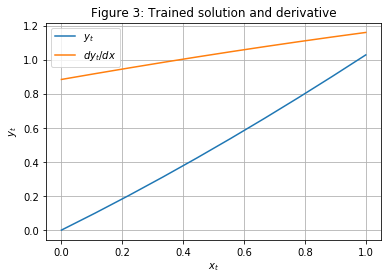

In [12]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.grid()
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

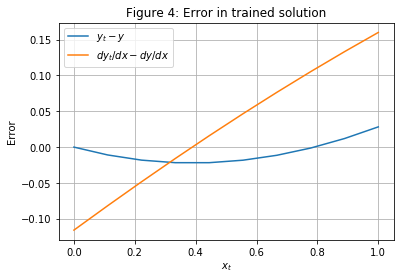

In [13]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number (20) of hidden nodes (this should improve the estimate of the solution and its derivative), and plot the error.

In [14]:
np.random.seed(0)
net.train(xt, nhid = 20)
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

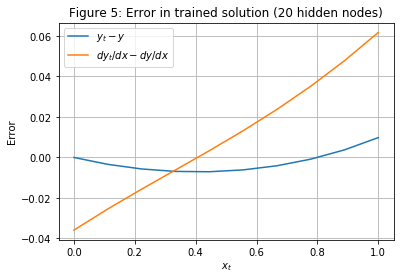

In [15]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a higher learning rate (which can also improve the solution), and plot the error.

In [16]:
np.random.seed(0)
net.train(xt, nhid = 20, eta = 0.02)
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

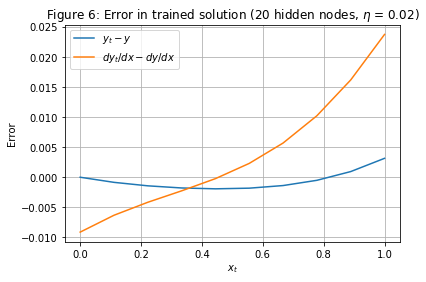

In [17]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 6: Error in trained solution (20 hidden nodes, $\eta$ = 0.02)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [18]:
np.random.seed(0)
net.train(xt, nhid = 20, eta = 0.02, maxepochs = 2000)
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

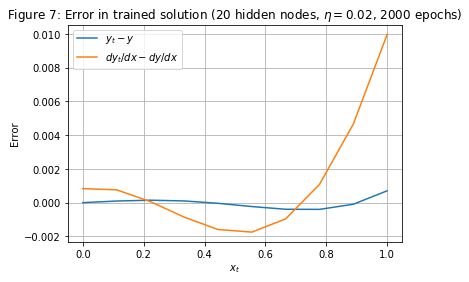

In [19]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 7: Error in trained solution (20 hidden nodes, $\eta=0.02$, 2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the file `ode00.py`, and can be imported (the directory containing the equation module must be in your module search path):

In [20]:
import ode00

We can now run the net using the information in this module.

In [21]:
np.random.seed(0)
net.train(xt)
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

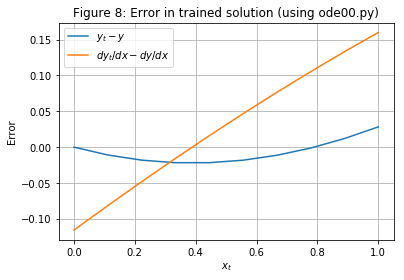

In [22]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode00.py)");

## History output

The code creates history files that allow examination of the evolution of the convergence as a whole, and of the individual parameters. These files contain 1 value per epoch, 1 epoch per line, and are called `rmse.dat` (history of RMS error values), `w.dat`, `u.dat`, and `v.dat` (for the individual parameter histories). These files are created in the current working directory. The contents of these files can be plotted as shown below.

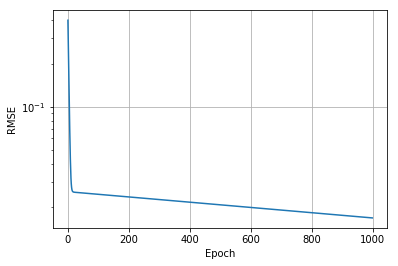

In [23]:
rmse = np.loadtxt('rmse.dat')
plt.semilogy(rmse)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid()

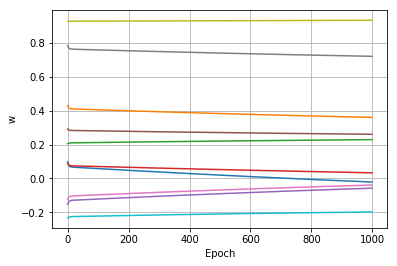

In [24]:
w = np.loadtxt('w.dat')
plt.plot(w)
plt.xlabel('Epoch')
plt.ylabel('w')
plt.grid()

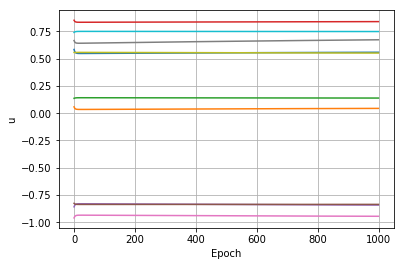

In [25]:
u = np.loadtxt('u.dat')
plt.plot(u)
plt.xlabel('Epoch')
plt.ylabel('u')
plt.grid()

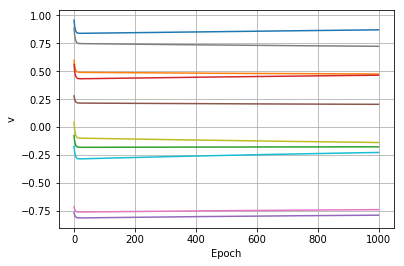

In [26]:
v = np.loadtxt('v.dat')
plt.plot(v)
plt.xlabel('Epoch')
plt.ylabel('v')
plt.grid()

## New training algorithm: Nelder-Mead Simplex Minimization

In [27]:
np.random.seed(0)
net = NNODE1IVP(ode)
net.train_neldermead(xt, verbose = True)

In [28]:
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

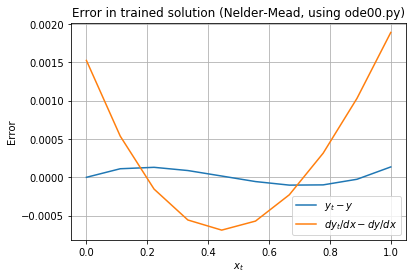

In [29]:
y = np.vectorize(ya)(xt)
dy_dx = np.vectorize(dya_dx)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Error in trained solution (Nelder-Mead, using ode00.py)");